In [2]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import palettable
from astropy.time import Time
from astropy.io import ascii
from astropy.table import Table

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [15]:
%matplotlib inline

In [26]:
# You can also directly read the web link:
data = ascii.read('https://swift.gsfc.nasa.gov/results/transients/weak/RapidBurster.lc.txt', format='commented_header',header_start=-2)

#filter out bad data
err_avg=np.average(data['ERROR'])
#data = ascii.read('RapidBurster.lc.txt', format='commented_header',header_start=-2)
formatted_time = Time((data['TIME'][(data['ERROR']<err_avg)]),format='mjd',out_subfmt='date_hms').isot
formatted_data = Table([formatted_time,data['RATE'][(data['ERROR']<err_avg)]],names=['ds','y']).to_pandas()

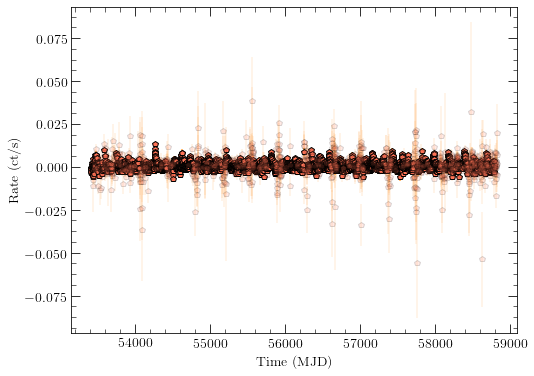

In [30]:
plt.figure(figsize=(8,6))

plt.errorbar(data['TIME']
[(data['ERROR']<err_avg)], data['RATE']
[(data['ERROR']<err_avg)], yerr=data['ERROR']
[(data['ERROR']<err_avg)], fmt='p',
             markeredgecolor='k',
             ecolor=palettable.cubehelix.cubehelix3_16.mpl_colors[11],
             color=palettable.cubehelix.cubehelix3_16.mpl_colors[10])

plt.errorbar(data['TIME']
[(data['ERROR']>err_avg)], data['RATE']
[(data['ERROR']>err_avg)], yerr=data['ERROR']
[(data['ERROR']>err_avg)], fmt='p',
             markeredgecolor='k',
             ecolor=palettable.cubehelix.cubehelix3_16.mpl_colors[11],
             color=palettable.cubehelix.cubehelix3_16.mpl_colors[10], alpha=0.15)

plt.minorticks_on()                                                              # To plot minor ticks
plt.tick_params(axis='both', which='major', labelsize=14)                        # To set tick label fontsize
plt.tick_params(axis='both', which='major', length=9)                            # To set tick size
plt.tick_params(axis='both', which='minor', length=4.5)                          # To set tick size
plt.tick_params(axis='both', which='both',direction='in',right=True, top=True)   # To plot ticks inwards instead of out
plt.xlabel('Time (MJD)', fontsize=14)
plt.ylabel('Rate (ct/s)', fontsize=14);

In [41]:
df = formatted_data

df_train=df[0:3000]
df_test=df[3000:]   # Note that element 3000 will be in df_train, but not in df_test (no need for 3001 instead of it)

In [42]:
m = Prophet()
m.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
future = m.make_future_dataframe(periods=665)
future.tail()

,ds
3660,2018-06-03
3661,2018-06-04
3662,2018-06-05
3663,2018-06-06
3664,2018-06-07


In [44]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3660,2018-06-03,0.001080,-0.001493,0.003595
3661,2018-06-04,0.001268,-0.001330,0.003640
3662,2018-06-05,0.001303,-0.001115,0.003760
3663,2018-06-06,0.001169,-0.001366,0.003623
3664,2018-06-07,0.001343,-0.001000,0.003627


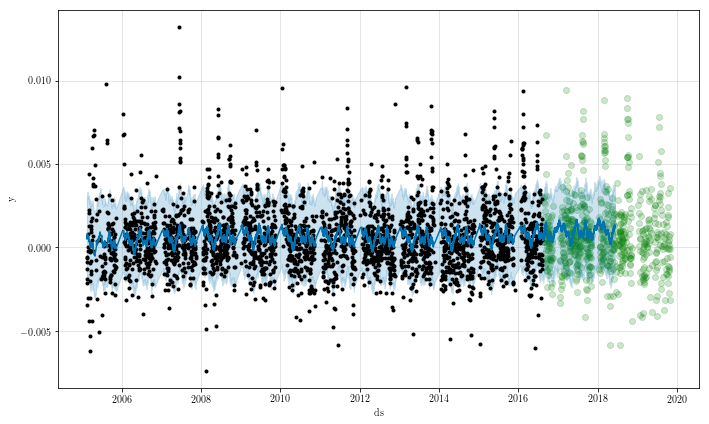

In [45]:
#plt.figure()
m.plot(forecast);
plt.plot_date(Time(data['TIME'][(data['ERROR']<err_avg)],format='mjd',out_subfmt='date_hms').datetime[3001:], data['RATE']
[(data['ERROR']<err_avg)][3001:], 'go', zorder=0, alpha=0.2)

#plt.savefig('forecast_test.pdf')